[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cyber\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Cyber\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Cyber\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
                                                Text label language  \
0   Top Trump Surrogate BRUTALLY Stabs Him In The...  Fake       en   
1  U.S. conservative leader optimistic of common ...  Real       en   
2  Trump proposes U.S. tax overhaul, stirs concer...  Real       en   
3   Court Forces Ohio To Allow Millions Of Illega...  Fake       en   
4  Democrats say Trump agrees to work on immigrat...  Real       en   

                                          clean_text  
0  top trump surrogate brutally stab back he path...  
1  u conservative leader optimistic common ground...  
2  trump propose

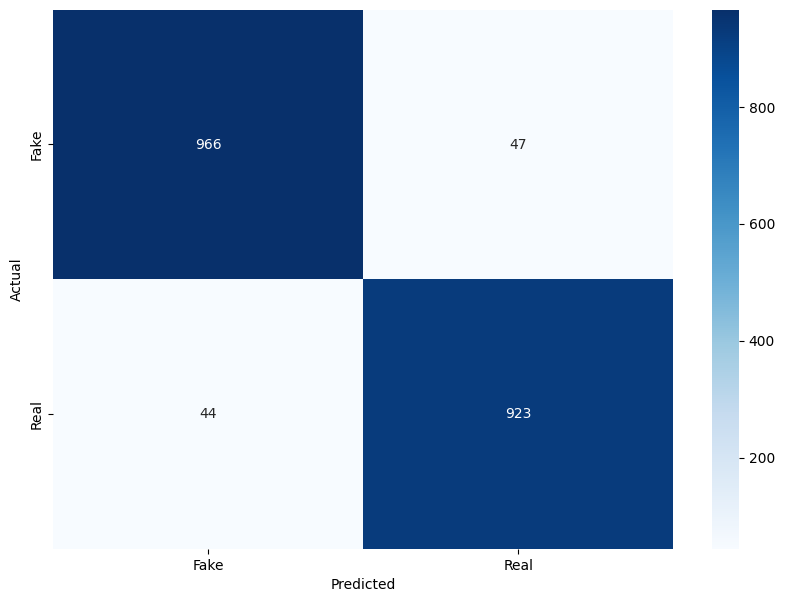

In [64]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from langdetect import detect
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tkinter as tk
from tkinter import ttk, messagebox
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure necessary NLTK data packages are downloaded
def download_nltk_data():
    nltk_data_path = os.path.join(os.getenv("USERPROFILE"), "nltk_data")  # Use USERPROFILE for Windows
    if not os.path.exists(nltk_data_path):
        os.makedirs(nltk_data_path)

    nltk.data.path.append(nltk_data_path)
    nltk.download('stopwords', download_dir=nltk_data_path)
    nltk.download('wordnet', download_dir=nltk_data_path)
    nltk.download('omw-1.4', download_dir=nltk_data_path)

class FakeNewsDetector:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = None
        self.vectorizer = None
        self.model = None
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def load_and_preprocess_data(self):
        # Load and preprocess dataset
        self.df = pd.read_csv(self.data_path)
        self.df = self.df[['Text', 'label']]
        self.df.dropna(inplace=True)

        # Language detection and filtering (keep only English articles)
        self.df['language'] = self.df['Text'].apply(lambda x: detect(x))
        self.df = self.df[self.df['language'] == 'en']

        # Text cleaning function
        self.df['clean_text'] = self.df['Text'].apply(self.clean_text)

        # Print sample data
        print(self.df.head())
        print("Label distribution:\n", self.df['label'].value_counts())

    def clean_text(self, text):
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        # Remove punctuation
        text = re.sub(r'[^\w\s]', '', text)
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Convert to lowercase
        text = text.lower()
        # Remove stopwords
        text = ' '.join([word for word in text.split() if word not in self.stop_words])
        # Lemmatize words
        text = ' '.join([self.lemmatizer.lemmatize(word) for word in text.split()])
        return text

    def train_model(self):
        # TF-IDF vectorization
        self.vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        X = self.vectorizer.fit_transform(self.df['clean_text'])
        y = self.df['label']

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

        # Train Naive Bayes classifier
        self.model = MultinomialNB()
        self.model.fit(X_train, y_train)

        # Predictions and evaluation
        y_pred = self.model.predict(X_test)
        print(classification_report(y_test, y_pred))
        print("Accuracy:", accuracy_score(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred, labels=['Fake', 'Real'])
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def classify_text(self, text):
        try:
            text_cleaned = self.clean_text(text)
            text_vectorized = self.vectorizer.transform([text_cleaned])
            prediction = self.model.predict(text_vectorized)
            prediction_proba = self.model.predict_proba(text_vectorized)

            result = "Real" if prediction[0] == 'Real' else "Fake"
            confidence = max(prediction_proba[0])

            return f"Classification: {result}\nConfidence: {confidence:.2f}"
        except Exception as e:
            return f"Error during classification: {str(e)}"

    def setup_gui(self):
        root = tk.Tk()
        root.title("Fake News Detection")

        # Create a frame for the input and result
        frame_input = ttk.Frame(root)
        frame_input.pack(pady=10)

        # Label and Entry for input
        input_label = ttk.Label(frame_input, text="Enter News Article:")
        input_label.pack(pady=10)

        self.input_entry = tk.Text(frame_input, height=10, width=50)
        self.input_entry.pack()

        # Button to detect fake news
        detect_button = ttk.Button(frame_input, text="Detect Fake News", command=self.detect_fake_news)
        detect_button.pack(pady=10)

        # Label to display the result
        self.result_label = ttk.Label(frame_input, text="")
        self.result_label.pack(pady=10)

        root.mainloop()

    def detect_fake_news(self):
        input_text = self.input_entry.get("1.0", tk.END).strip()  # Retrieve text and strip extra whitespace
        if not input_text:
            messagebox.showerror("Error", "Please enter a news article.")
        else:
            result = self.classify_text(input_text)
            self.result_label.config(text=result)

# Usage
if __name__ == "__main__":
    download_nltk_data()  # Download NLTK data before proceeding
    detector = FakeNewsDetector('Task5/fake_and_real_news.csv')
    detector.load_and_preprocess_data()
    detector.train_model()
    detector.setup_gui()